<a href="https://colab.research.google.com/github/sdding/Project/blob/main/Ai_06_%EC%9D%B4%EC%8A%B9%EC%88%98_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SECTION 2 - PROJECT**

# Health Insurance Cross Sell Prediction 
### Predict Health Insurance Owners' who will be interested in Vehicle Insurance

1. id - 고객의 ID 
2. Gender -	성별  
3. Age - 나이  
4. Driving_License - 0 : 운전면허 없음 / 1 : 운전면허 있음
5. Region_Code - 고객이 사는 지역코드
6. Previously_Insured	
1 : 이미 차량보험 있음 / 0 : 차량보험 없음
7. Vehicle_Age - 차량의 노후정도
8. Vehicle_Damage  
1 : 과거에 차량이 파손된 적이 있음 / 0 : 차량이 파손된 적이 없음
9. Annual_Premium	- 고객이 연도에 보험료로 지불해야 하는 금액 
10. PolicySalesChannel - 고객에게 연락하는 채널에 대한 익명화된 코드, 즉. 다양한 상담원, 우편, 전화, 직접 방문 등  
11. Vintage -	고객이 회사와 연결되어 있었던 일 수
12. **Response - 1 : Customer is interested / 0 : Customer is not interested**

귀하의 클라이언트는 고객에게 건강 보험을 제공한 보험 회사입니다. 이제 그들은 작년의 보험 계약자(고객)가 회사에서 제공한 차량 보험에 관심을 가질지 여부를 예측하는 모델을 구축하는 것이 목표

고객이 자동차 보험에 관심을 가질지 여부를 예측하는 모델을 구축하는 것은 회사에 매우 도움이 됩니다. 그 이유는 그에 따라 해당 고객에게 다가가 비즈니스 모델과 수익을 최적화하기 위한 커뮤니케이션 전략을 계획할 수 있기 때문입니다.

In [ ]:
!pip install category_encoders
!pip install -U scikit-learn
!pip install PDPbox
!pip install shap
!pip install eli5
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
import pandas as pd
import numpy as np
train = pd.read_csv("/content/train.csv")
train_F = pd.read_csv("/content/train.csv")
print(train.shape)
train.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### 1) 데이터 선정 이유
향후에 어떤 방식으로 고객에게 접근해야 보험에 가입을 할지를 예측하기 위해 이 데이터를 선택했음
### 분류 / 회귀
차량보험에 관심을 가질지 안가질지를 판단하는 이진분류문제이다
## 가설
보험료의 가격이 차량 보험 관심에 영향을 준다

In [9]:
# target의 수와 비율
pd.concat([pd.DataFrame(train[['Response']].value_counts(), columns = ['count']), pd.DataFrame(train[['Response']].value_counts(normalize=True), columns = ['rate'])], axis = 1)

# 기준모델 0.877437 
# 클래스가 불균형한 분류 문제
# 타겟의 비율이 70%를 넘으므로 클래스 불균형을 맞춘 후 평가지표로 ROC curve, AUC, f1 score사용

,count,rate
Response,,
0,334399,0.877437
1,46710,0.122563


In [10]:
pd.DataFrame(train.isnull().sum(), columns=["결측치 개수"])

,결측치 개수
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
pd.DataFrame(train.duplicated(list(train.columns)).value_counts(), columns=['중복값 개수'])

,중복값 개수
False,381109


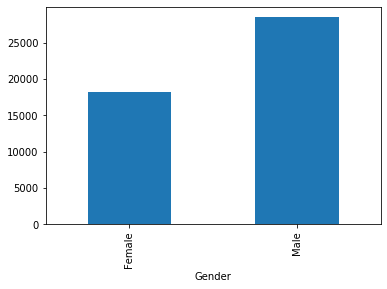

In [ ]:
train.groupby('Gender')['Response'].sum().plot(kind='bar')

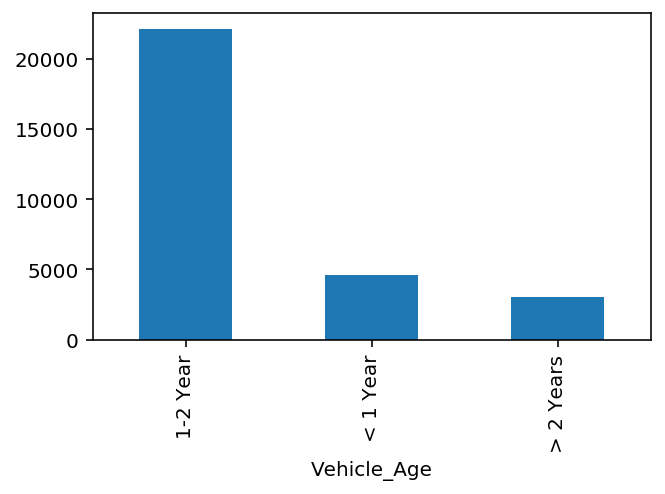

In [ ]:
train.groupby('Vehicle_Age')['Response'].sum().plot(kind='bar', figsize=(5, 3))

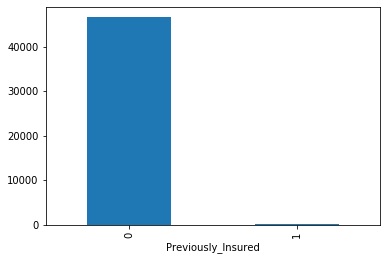

In [ ]:
train.groupby('Previously_Insured')['Response'].sum().plot(kind='bar')

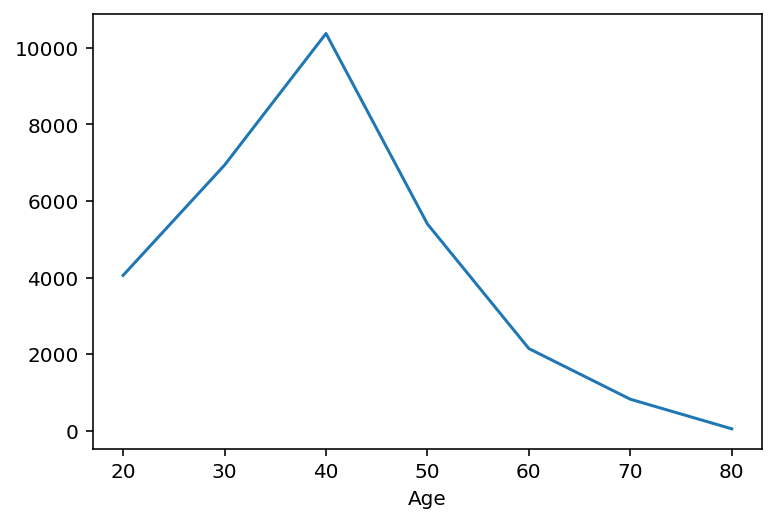

In [ ]:
# 나이별 가입수 그래프
train.groupby('Age')['Response'].sum().plot()
# 그래프를 보아 40대에서 가장 높은 수치를 보여준다

In [ ]:
# 높은 cardinality인 특성
len(train['Region_Code'].unique()), len(train['Policy_Sales_Channel'].unique())

(53, 155)

In [5]:
# 나이대별 분류
def trans_Age(n):       
  for i in range(20,90,10):
    if (n >= i) & (n < i+10):
      n = i
  return n

# 회사와 연결되어 있던 개월 수 
def trans_V(n):
  for i in range(0, 360, 30):
    if (n >= i) & (n < i+30):
      n = i / 30
  return int(n)

In [11]:
# 전처리
def eng(df):
  df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'Yes':1, 'No':0})
  
  df['Region_Code'] = df['Region_Code'].astype(int)
  df['Annual_Premium'] = df['Annual_Premium'].astype(int)
  df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

  df.drop(['id', 'Region_Code', 'Policy_Sales_Channel'],axis=1,inplace=True)    # 단순 번호인 ID와 지역코드, 판매 종류 코드 삭제

  df['Age'] = df['Age'].apply(trans_Age)
  df['Vintage'] = df['Vintage'].apply(trans_V)
  return df

eng(train)
eng(train_F)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Male,40,1,0,> 2 Years,1,40454,7,1
1,Male,70,1,0,1-2 Year,0,33536,6,0
2,Male,40,1,0,> 2 Years,1,38294,0,1
3,Male,20,1,1,< 1 Year,0,28619,6,0
4,Female,20,1,1,< 1 Year,0,27496,1,0
...,...,...,...,...,...,...,...,...,...
381104,Male,70,1,1,1-2 Year,0,30170,2,0
381105,Male,30,1,1,< 1 Year,0,40016,4,0
381106,Male,20,1,1,< 1 Year,0,35118,5,0
381107,Female,60,1,0,> 2 Years,1,44617,2,0


In [12]:
from sklearn.model_selection import train_test_split

# 타겟은 가입여부 'Response'
target = 'Response'
# train 데이터를 훈련/검증/테스트로 분리
train, test = train_test_split(train, test_size=0.15, stratify=train[target], random_state=2)
train, val = train_test_split(train, test_size=0.25, stratify=train[target], random_state=2)

# 타겟 / 특성 분리
features = train.drop(columns=[target]).columns

X_train_F = train_F[features]   # 최종훈련데이터
y_train_F = train_F[target]

X_train = train[features]       # 훈련데이터
y_train = train[target]
X_val = val[features]           # 검증데이터
y_val = val[target]

X_test = test[features]         # 테스트데이터
y_test = test[target]
X_train.shape, X_val.shape, X_test.shape

((242956, 8), (80986, 8), (57167, 8))

In [14]:
# 불균형 클래스이므로 밸런스 맞추기
balance = len(y_train)/(2*np.bincount(y_train))
balance

array([0.56984037, 4.07959163])

In [13]:
from category_encoders import OrdinalEncoder       
from category_encoders import OneHotEncoder                             
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 1. 선형모델
linear = LinearRegression()

# 숫자형 특성 
features = ['Age', 'Annual_Premium']
X_train1 = X_train[features]
X_val1 = X_val[features]
X_test1 = X_test[features]
linear.fit(X_train1, y_train)
print('선형모델 숫자형 특성 검증세트 정확도: ', linear.score(X_val1, y_val))

# 특성의 회귀계수
pd.Series(linear.coef_, features)

선형모델 숫자형 특성 검증세트 정확도:  0.011936335488594074


Age               2.276388e-03
Annual_Premium    2.699245e-07
dtype: float64

In [19]:
# 2.로지스틱 회귀모델
logistic = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(class_weight={False:balance[0],True:balance[1]})
    )
logistic.fit(X_train, y_train)
y_pred_l = logistic.predict(X_val)
print("로지스틱 회귀모델 검증세트 정확도 :", logistic.score(X_val, y_val))

로지스틱 회귀모델 검증세트 정확도 : 0.6956264045637518


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
from sklearn.metrics import roc_auc_score, precision_score

y_pred_proba_l = logistic.predict_proba(X_val)[:, -1]
print("로지스틱 회귀모델 검증세트 AUC score :", roc_auc_score(y_val, y_pred_proba_l))
print("로지스틱 회귀모델 검증세트 F1 score :", f1_score(y_val, y_pred_l))

로지스틱 회귀모델 검증세트 AUC score : 0.8051822949437433
로지스틱 회귀모델 검증세트 F1 score : 0.402569074163839


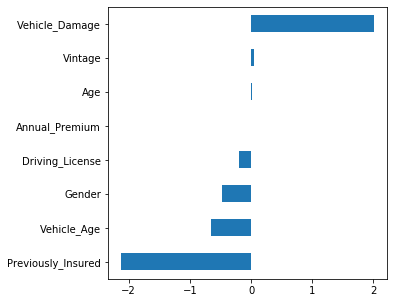

In [21]:
# 로지스틱 모델의 특성들의 회귀 계수
import matplotlib.pyplot as plt

model_lr = logistic.named_steps['logisticregression']
pre = logistic.named_steps['ordinalencoder']
encoded_columns = pre.transform(X_val).columns
coefficients = pd.Series(model_lr.coef_[0], encoded_columns)
plt.figure(figsize=(5,5))
coefficients.sort_values().plot.barh();

In [22]:
# 3. 결정트리모델
pipe1 = make_pipeline(
    OrdinalEncoder(),  
    DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, random_state=2, class_weight={False:balance[0],True:balance[1]})
)

pipe1.fit(X_train, y_train)

print('결정트리모델 검증세트 정확도 :', pipe1.score(X_val, y_val))

결정트리모델 검증세트 정확도 : 0.6818956362828144


In [23]:
y_pred1 = pipe1.predict(X_val)
y_pred_proba1 = pipe1.predict_proba(X_val)[:, -1]
print('결정트리모델 검증세트 AUC score :', roc_auc_score(y_val, y_pred_proba1))
print("결정트리모델 검증세트 F1 score :", f1_score(y_val, y_pred1))

결정트리모델 검증세트 AUC score : 0.838159799487783
결정트리모델 검증세트 F1 score : 0.41704380883417813


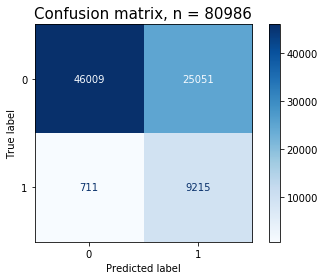

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     71060
           1       0.27      0.93      0.42      9926

    accuracy                           0.68     80986
   macro avg       0.63      0.79      0.60     80986
weighted avg       0.90      0.68      0.74     80986



In [24]:
# 결정트리모델 confusion matrix
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe1, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred1))

In [25]:
import eli5
from eli5.sklearn import PermutationImportance

pipe1 = Pipeline([
    ('preprocessing', OrdinalEncoder()),
    ('DT', DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)) 
])

{'preprocessing': OrdinalEncoder(),
 'DT': DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)}

pipe1.fit(X_train, y_train)

permuter = PermutationImportance(
    pipe1.named_steps['DT'],
    scoring='f1', 
    n_iter=5, 
    random_state=2
)

X_val_transformed = pipe1.named_steps['preprocessing'].transform(X_val)       # 검증세트 인코딩

permuter.fit(X_val_transformed, y_val);

feature_names = X_train.columns.tolist()

# 중요도
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Vehicle_Damage        0.093283
Previously_Insured    0.077541
Age                   0.013864
Vehicle_Age           0.011189
Gender                0.005993
Vintage               0.000000
Annual_Premium        0.000000
Driving_License       0.000000
dtype: float64

In [26]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,  
    feature_names=feature_names 
)

Weight,Feature
0.0933 ± 0.0033,Vehicle_Damage
0.0775 ± 0.0073,Previously_Insured
0.0139 ± 0.0009,Age
0.0112 ± 0.0008,Vehicle_Age
0.0060 ± 0.0012,Gender
0 ± 0.0000,Vintage
0 ± 0.0000,Annual_Premium
0 ± 0.0000,Driving_License


In [27]:
# 중요도가 0.001보다 큰 특성만 골라 예측
mask = permuter.feature_importances_ >= 0.001
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

pipe1.fit(X_train_selected, y_train);
y_pred1 = pipe1.predict(X_val_selected)
print('검증 정확도: ', pipe1.score(X_val_selected, y_val))

y_pred_proba1 = pipe1.predict_proba(X_val_selected)[:, -1]
print("결정트리모델 특성 선택 후 검증세트 AUC score: ", roc_auc_score(y_val, y_pred_proba1))
print("결정트리모델 특성 선택 후 검증세트 F1 score :", f1_score(y_val, y_pred1))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.6818956362828144
결정트리모델 특성 선택 후 검증세트 AUC score:  0.8383331141014858
결정트리모델 특성 선택 후 검증세트 F1 score : 0.41704380883417813


In [28]:
# 결정트리 모델 하이퍼파라미터 조정
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists1 = {     
    'DT__min_samples_leaf': randint(50, 500), 
    'DT__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

clf1 = RandomizedSearchCV(
    pipe1, 
    param_distributions=dists1, 
    n_iter=40,
    cv=5,
    scoring='f1',    # 평가지표는 재현율
    n_jobs = -1,
    verbose = 1
)

clf1.fit(X_train_selected, y_train);
print('최적 하이퍼파라미터: ', clf1.best_params_)
print('F1 score: ', clf1.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


최적 하이퍼파라미터:  {'DT__max_depth': 6, 'DT__min_samples_leaf': 317}
F1 score:  0.4189543596847402


In [30]:
best1 = clf1.best_estimator_    # 가장 성능 좋은 모델
y_pred1_b = best1.predict(X_val_selected)
y_pred_proba1_b = best1.predict_proba(X_val_selected)[:, 1]

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba1_b)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('임계값 :', optimal_threshold)

y_pred_optimal1 = y_pred_proba1_b >= optimal_threshold
y_pred_optimal1 = y_pred_optimal1.astype(int)
from sklearn.metrics import roc_auc_score
print("파라미터 조정 후 검증세트 AUC 점수 :", roc_auc_score(y_val, y_pred_optimal1))
print("파라미터 조정 후 검증세트 F1 score :", f1_score(y_val, y_pred_optimal1))

임계값 : 0.5476317994192227
파라미터 조정 후 검증세트 AUC 점수 : 0.7881072923024697
파라미터 조정 후 검증세트 F1 score : 0.4237654466005732


In [ ]:
# 4. 랜덤포레스트모델
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=2, oob_score=True, class_weight={False:balance[0],True:balance[1]})
)

pipe2.fit(X_train, y_train)

print('랜덤포레스트모델 검증 정확도: ', pipe2.score(X_val, y_val))

랜덤포레스트모델 검증 정확도:  0.6675845207813697


In [ ]:
from sklearn.metrics import roc_auc_score
y_pred2 = pipe2.predict(X_val)
y_pred_proba2 = pipe2.predict_proba(X_val)[:, -1]
print('랜덤포레스트모델 검증 AUC score :', roc_auc_score(y_val, y_pred_proba2))
print("랜덤포레스트모델 검증세트 F1 score :", f1_score(y_val, y_pred2))

랜덤포레스트모델 검증 AUC score : 0.8394115306348884
랜덤포레스트모델 검증세트 F1 score : 0.41018337970773167


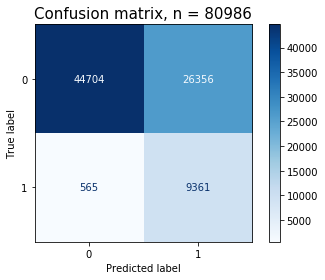

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     71060
           1       0.26      0.94      0.41      9926

    accuracy                           0.67     80986
   macro avg       0.62      0.79      0.59     80986
weighted avg       0.90      0.67      0.72     80986



In [ ]:
# 랜덤포레스트모델 confusion matrix
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe2, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred2))

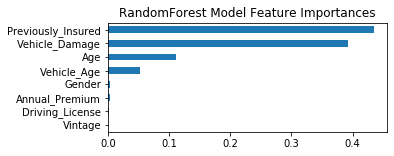

In [ ]:
# 랜덤포레스트모델 특성 중요도
rf_ord = pipe2.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)
n=len(X_train.columns)
plt.figure(figsize=(5,n/4))
plt.title(f'RandomForest Model Feature Importances')
importances_ord.sort_values()[-n:].plot.barh();

In [ ]:
# 랜덤포레스트 순열 중요도
import eli5
from eli5.sklearn import PermutationImportance

pipe2 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('RF', RandomForestClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2, n_jobs=-1)) 
])

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder())]),
 'RF': RandomForestClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2, n_jobs=-1)}

pipe2.fit(X_train, y_train)

permuter = PermutationImportance(
    pipe2.named_steps['RF'],
    scoring='f1', 
    n_iter=5, 
    random_state=2
)

X_val_transformed = pipe2.named_steps['preprocessing'].transform(X_val)       # 검증세트 인코딩

permuter.fit(X_val_transformed, y_val);

feature_names = X_train.columns.tolist()

# 중요도
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Vehicle_Damage        0.091288
Previously_Insured    0.075114
Age                   0.007901
Vehicle_Age           0.007362
Gender                0.003488
Annual_Premium        0.000786
Driving_License       0.000427
Vintage              -0.000434
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,  
    feature_names=feature_names 
)

Weight,Feature
0.0913 ± 0.0033,Vehicle_Damage
0.0751 ± 0.0068,Previously_Insured
0.0079 ± 0.0006,Age
0.0074 ± 0.0006,Vehicle_Age
0.0035 ± 0.0004,Gender
0.0008 ± 0.0004,Annual_Premium
0.0004 ± 0.0001,Driving_License
-0.0004 ± 0.0005,Vintage


In [ ]:
# 중요도가 0.001보다 큰 특성만 골라 예측
mask = permuter.feature_importances_ > 0.001
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

pipe2.fit(X_train_selected, y_train);
y_pred2 = pipe2.predict(X_val_selected)
print('검증 정확도: ', pipe2.score(X_val_selected, y_val))

y_pred_proba2 = pipe2.predict_proba(X_val_selected)[:, -1]
print('랜덤포레스트모델 특성 선택 후 검증세트 AUC score: ', roc_auc_score(y_val, y_pred_proba2))
print("랜덤포레스트모델 특성 선택 후 검증세트 F1 score :", f1_score(y_val, y_pred2))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.6818956362828144
랜덤포레스트모델 특성 선택 후 검증세트 AUC score:  0.8392141936170612
랜덤포레스트모델 특성 선택 후 검증세트 F1 score : 0.41704380883417813


In [ ]:
# 랜덤포레스트 모델 하이퍼파라미터 조정
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists2 = {     
    'RF__n_estimators': randint(100, 500), 
    'RF__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

clf2 = RandomizedSearchCV(
    pipe2, 
    param_distributions=dists2, 
    n_iter=30,
    cv=4,
    scoring='f1',    # 평가지표는 재현율
    n_jobs = -1,
    verbose = 1
)

clf2.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf2.best_params_)
print('F1 score: ', clf2.best_score_)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


최적 하이퍼파라미터:  {'RF__max_depth': 10, 'RF__n_estimators': 289}
F1 score:  0.4166351278041769


In [ ]:
best2 = clf2.best_estimator_    # 가장 성능 좋은 모델
y_pred2_b = best2.predict(X_val)
y_pred_proba2_b = best2.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba2_b)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx2 = np.argmax(tpr - fpr)
optimal_threshold2 = thresholds[optimal_idx]
print('임계값 :', optimal_threshold)

y_pred_optimal2 = y_pred_proba2_b >= optimal_threshold2
y_pred_optimal2 = y_pred_optimal2.astype(int)

print("파라미터 조정 후 검증세트 AUC 점수 :", roc_auc_score(y_val, y_pred_optimal))
print("파라미터 조정 후 검증세트 F1 score :", f1_score(y_val, y_pred_optimal))

임계값 : 0.5476317994192227
파라미터 조정 후 검증세트 AUC 점수 : 0.7885770306800013
파라미터 조정 후 검증세트 F1 score : 0.4204592517601584


In [ ]:
# 5. XGBoost 모델
pipe3 = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(max_depth=5, n_estimators=100, class_weight={False:balance[0],True:balance[1]}, random_state=2)
)

pipe3.fit(X_train, y_train)

print('XGBoost 모델 검증 정확도: ', pipe3.score(X_val, y_val))

XGBoost 모델 검증 정확도:  0.8774109105277456


In [ ]:
from sklearn.metrics import roc_auc_score
y_pred3 = pipe3.predict(X_val)
y_pred_proba3 = pipe3.predict_proba(X_val)[:, -1]
print('XGBoost 모델 AUC score: ', roc_auc_score(y_val, y_pred_proba3))
print("XGBoost 모델 검증세트 F1 score :", f1_score(y_val, y_pred3))
# f1 score가 너무 낮다

XGBoost 모델 AUC score:  0.8430659402800539
XGBoost 모델 검증세트 F1 score : 0.00020140986908358512


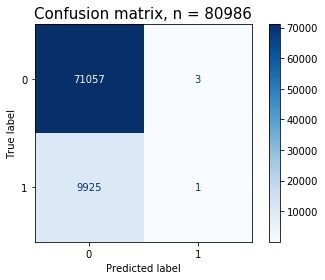

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     71060
           1       0.25      0.00      0.00      9926

    accuracy                           0.88     80986
   macro avg       0.56      0.50      0.47     80986
weighted avg       0.80      0.88      0.82     80986



In [ ]:
# XGBoost모델 confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe3, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred3))


# 모델 선택
---
# 1. 로지스틱 회귀모델  
* AUC score : 0.805181
* F1 score : 0.402549

# 2. 결정트리모델 
* AUC score : 0.838159
* F1 score : 0.417043

### 특성 선택 후
* AUC score:  0.838333  
* F1 score : 0.4170438  

### 파라미터 조정 후 ✔️
* AUC score : 0.788107  
* F1 score : 0.423765

# 3. 랜덤포레스트모델 
### 기준 모델
* AUC score :  0.839411 
* F1 score :  0.410183

### 특성 선택 후
* AUC score:  0.839214  
* F1 score : 0.417043  

### 파라미터 조정 후
* AUC score : 0.788577  
* F1 score : 0.420459

# 4. XGBoost 모델
* AUC score:  0.843065
* F1 score : 0.00020140



In [31]:
# 최종모델로 예측
best1.fit(X_train_F, y_train_F)
y_pred_t = best1.predict(X_test)
y_pred_proba_t = best1.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_t)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# 임계값 구하기
optimal_idx_t = np.argmax(tpr - fpr)
optimal_threshold_t = thresholds[optimal_idx]
print('임계값 :', optimal_threshold_t)

y_pred_optimal_t = y_pred_proba_t >= optimal_threshold_t
y_pred_optimal_t = y_pred_optimal_t.astype(int)
print("테스트세트 AUC 점수 :", roc_auc_score(y_test, y_pred_optimal_t))
print("테스트세트 F1 score :", f1_score(y_test, y_pred_optimal_t))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


임계값 : 0.6090529481152538
테스트세트 AUC 점수 : 0.7796071253308096
테스트세트 F1 score : 0.4335061710362959


# 최종모델(결정트리모델) 

## 테스트데이터 F1 score : 0.433506

# PDP plot / SHAP  시각화

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


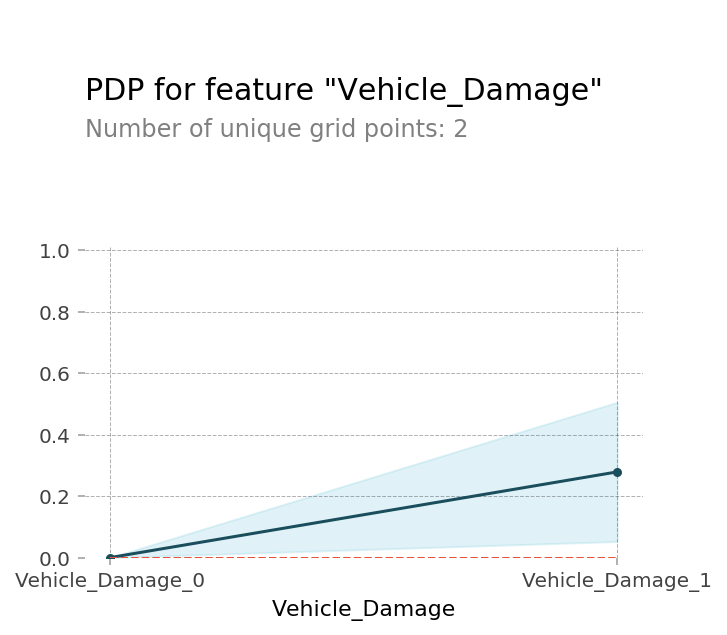

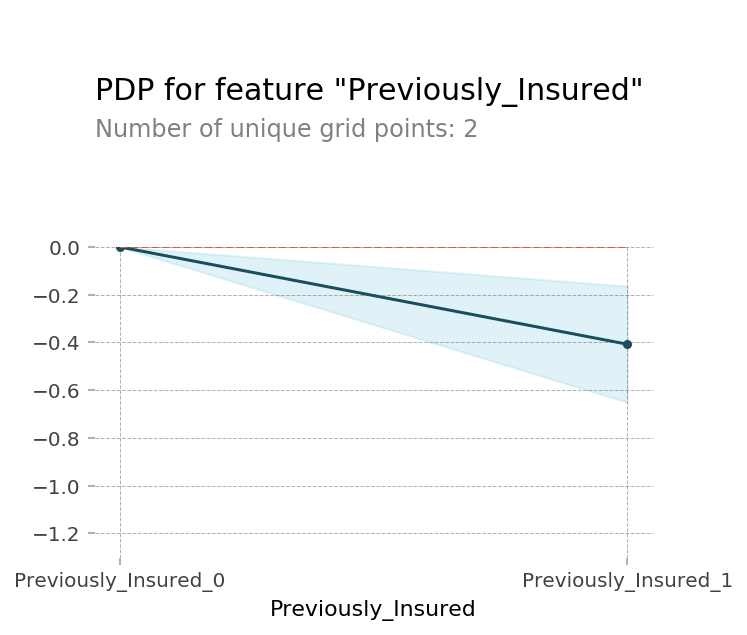

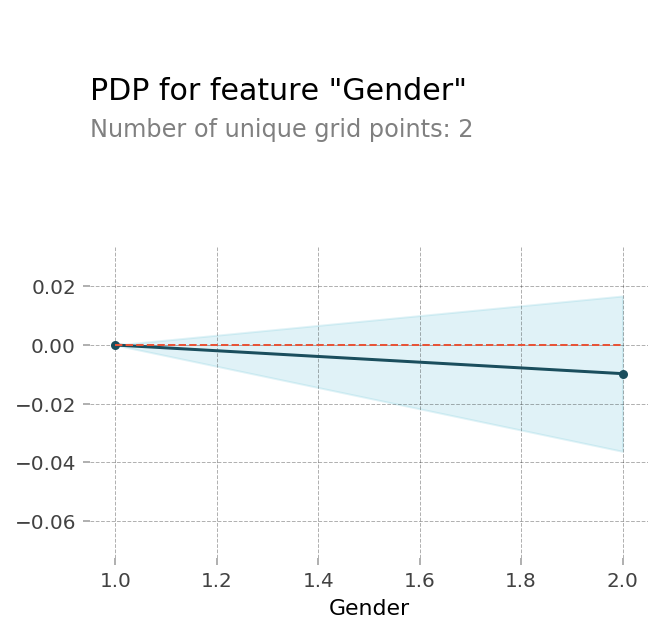

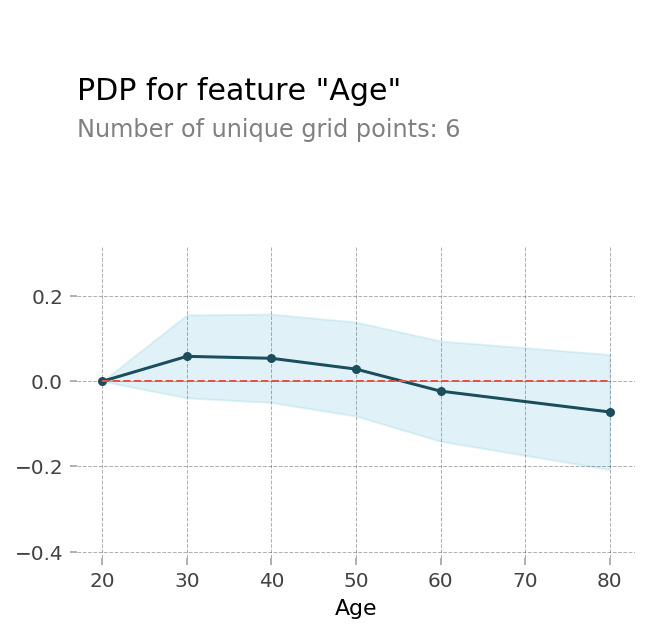

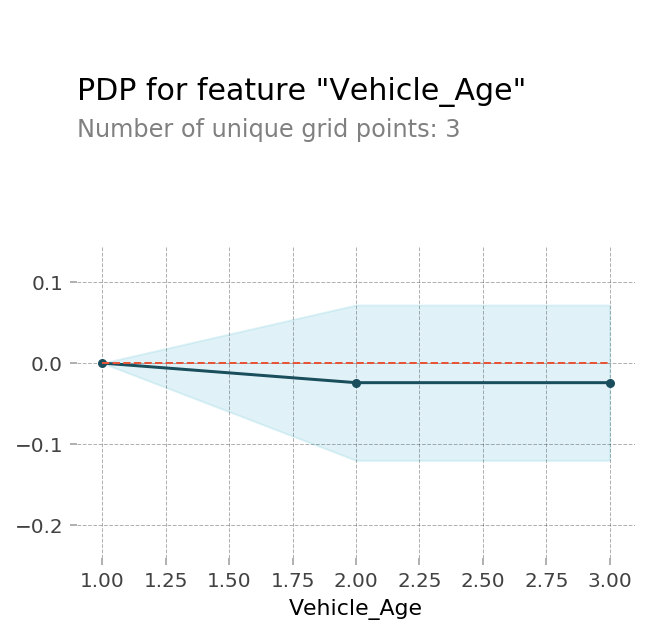

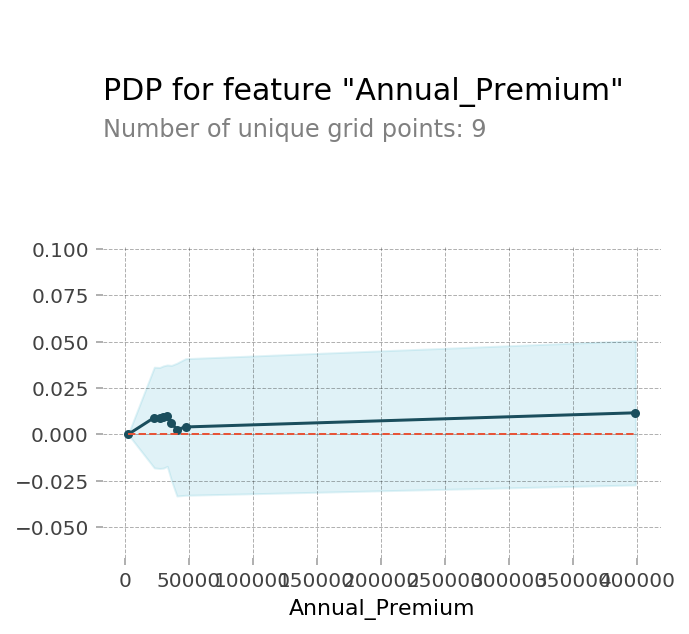

In [50]:
# 시각화
import sklearn
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
from pdpbox.pdp import pdp_isolate, pdp_plot

encoder = best1.named_steps['preprocessing']
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

tree = best1.named_steps['DT']

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

tree.fit(X_train_encoded, y_train)

feature = ['Vehicle_Damage', 'Previously_Insured', 'Gender', 'Age', 'Vehicle_Age', 'Annual_Premium']

for i in range(len(feature)):
  isolated = pdp_isolate(
      model=tree, 
      dataset=X_test_encoded, 
      model_features=X_test_encoded.columns,
      feature=feature[i],
      grid_type='percentile',
      num_grid_points=10 
  )
  pdp_plot(isolated, feature_name=feature[i], figsize=(5, 5));

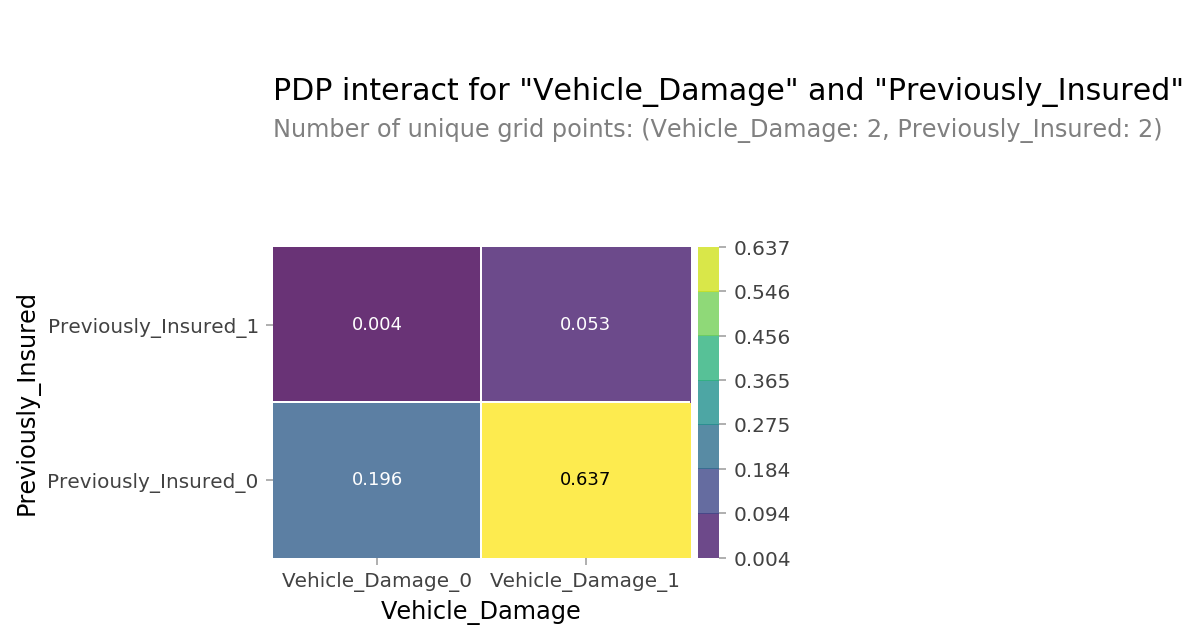

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Vehicle_Damage', 'Previously_Insured']

interaction = pdp_interact(
    model=tree, 
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features, figsize=(4, 5));

In [ ]:
!pip install pdpbox
!pip install shap
import warnings
warnings.filterwarnings(action='ignore')

In [65]:
import shap
shap.initjs()

encoder = best1.named_steps['preprocessing']
X_train_encoded = encoder.fit_transform(X_train)   # 학습데이터
X_val_encoded = encoder.transform(X_val)           # 검증데이터
X_test_encoded = encoder.transform(X_test)         # 테스트데이터

tree = best1.named_steps['DT']

tree.fit(X_train_encoded, y_train)

row = X_train_encoded.iloc[[11]]

explainer = shap.TreeExplainer(tree)
row_encoded = encoder.transform(row)
shap_values = explainer.shap_values(row_encoded)

In [66]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' 
)

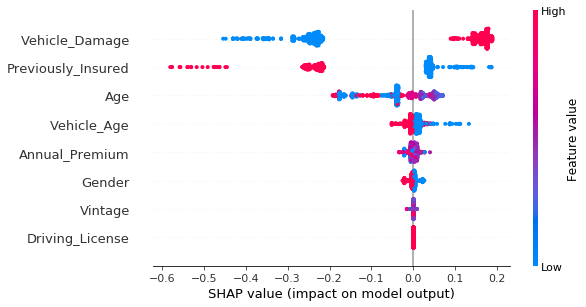

In [35]:
shap.initjs()
shap_values = explainer.shap_values(X_train_encoded.iloc[:1000])
shap.summary_plot(shap_values[1], X_train_encoded.iloc[:1000])

1. Previously_Insured : 차량보험이 있는 사람이 1(High) 없는 사람이 0(Low)여서  
낮은 값인 0 파랑이 모델 성능을 높이는 영향을 준다
2. Vehicle_Damage : 차량 파손 경험이 있는 사람이 1(High) 없는 사람이 0(Low)여서  
경험이 있는 사람이(High) 성능을 높인다
3. Age : 연령대별로 나눴을 때 보라색인 40대 정도에서 모델 성능을 높인다.  
너무 나이가 많거나 어린사람은 모델 성능을 낮춘다

In [47]:
shap.initjs()
shap_values = explainer.shap_values(X_train_encoded.iloc[:1000])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train_encoded.iloc[:1000])

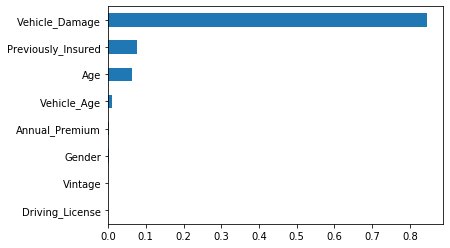

In [46]:
importances = pd.Series(tree.feature_importances_, X_train_encoded.columns)
importances.sort_values().plot.barh();